In [91]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (16, 9)

## Image Stitching 

This problem will walk you through the process of image stitching by detecting and matching corners, and estimating the homography based the matches.

### Detect Keypoints and Calculate Descriptors

Load the sample image pair.

In [92]:
img1 = cv2.imread('data/graff1.png')
img2 = cv2.imread('data/graff2.png')

In the cell below, detect feature points and calculate their descriptors in both images using OpenCV's ORB detector and descriptor.

In [93]:
kps1, des1 = cv2.ORB_create().compute(img1, cv2.ORB_create().detect(img1))
kps2, des2 = cv2.ORB_create().compute(img2, cv2.ORB_create().detect(img2))

Visualize locations of detected features.

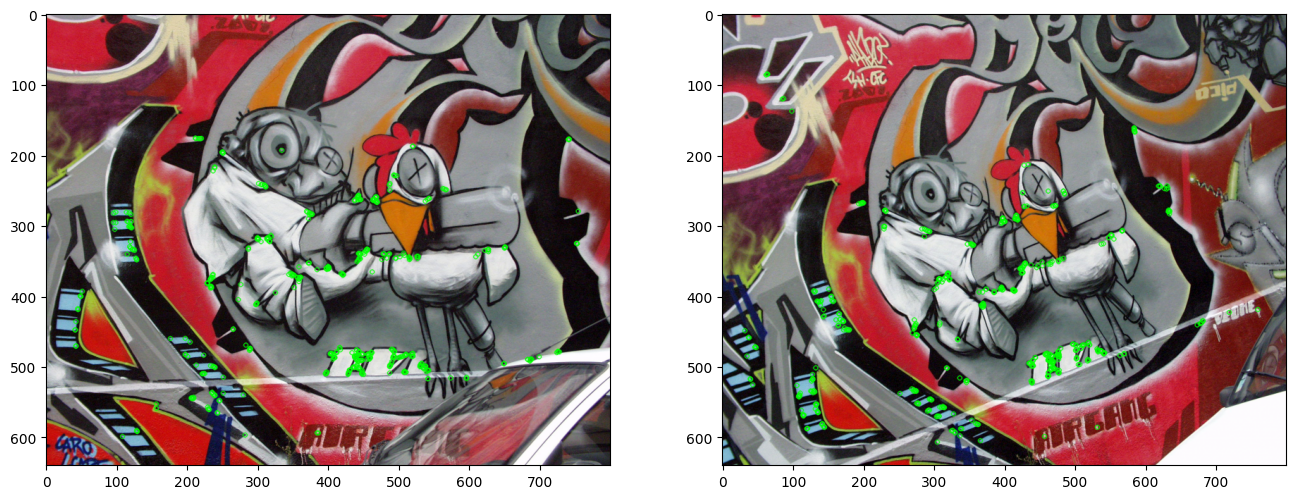

In [94]:
kp_img1 = cv2.drawKeypoints(img1, kps1, None, color=(0,255,0))
kp_img2 = cv2.drawKeypoints(img2, kps2, None, color=(0,255,0))

fig, axs = plt.subplots(1, 2)
axs[0].imshow(cv2.cvtColor(kp_img1, cv2.COLOR_BGR2RGB))
axs[1].imshow(cv2.cvtColor(kp_img2, cv2.COLOR_BGR2RGB))
plt.show()

### Match Keypoints

Using `cv2.BFMatcher`, calculate the matching between the two lists of keypoints. Be sure to use the correct distance measurement. Also, set `crossCheck=True` when creating the matcher. After you get the matches, sort them by distance and call `cv2.drawMatches()` to display the 100 closest matches.

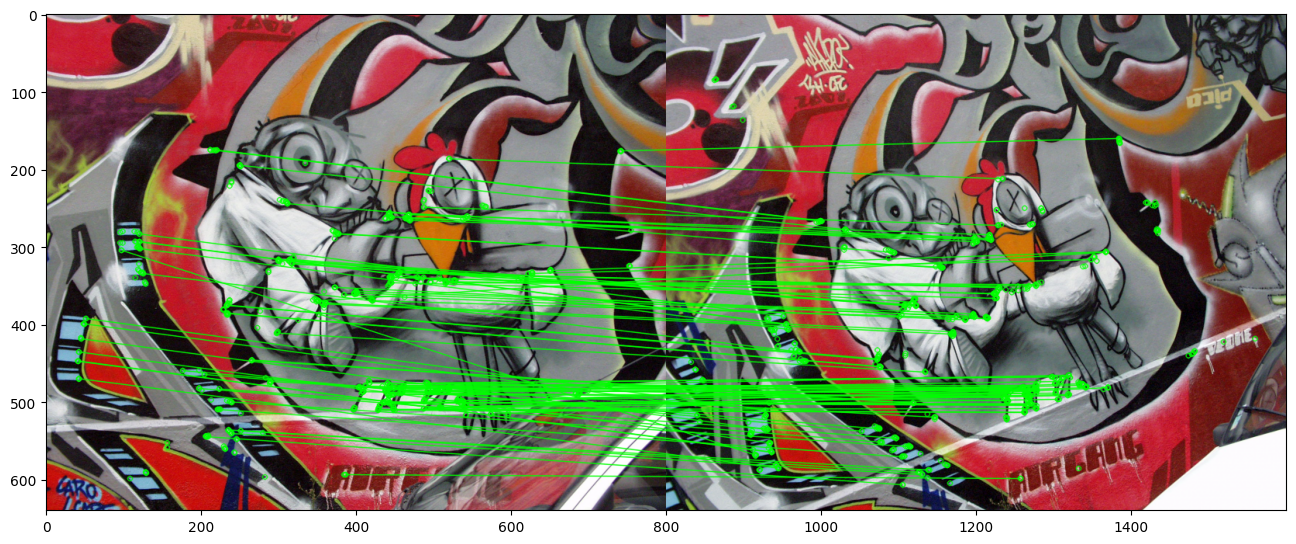

In [98]:
matches = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True).match(des1, des2)
match_img = cv2.drawMatches(img1, kps1, img2, kps2, matches[:100], None,
    matchColor=(0,255,0), singlePointColor=(0,255,0))
plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
plt.show()

### Calculate Homography Between Matching Keypoints

The following function calculates the projective transformation that maps a list of (x, y) coordinates `pts1` to the list of matching coordinates `pts2`. The return value is a 3x3 array representing the transformation matrix. You don't need to worry about there being outlier matches between `pts1` and `pts2` here. 

In [99]:
def get_homography(pts1, pts2):
    """Estimate the affine transformation between two lists of matching
    keypoint coordinates.
    
    Args:
    - pts1: List of (x, y) coordinates.
    - pts2: List of (x, y) coordinates.
    
    Returns:
    - t: 3x3 array representing the projective transformation matrix that
          maps `pts1` to `pts2`.
    """
    assert len(pts1) == len(pts2), \
        "`pts1` and `pts2` must have equal length."
    
    assert len(pts1) >= 4, \
        "at least 4 point-correspondences"
    
    length = len(pts1)
    # build the matrix A
    A = []
    for i in range(length):
        x1, y1 = pts1[i]
        x2, y2 = pts2[i]
        A.append([x1, y1, 1, 0, 0, 0, -x2 * x1, -x2 * y1, -x2])
        A.append([0, 0, 0, x1, y1, 1, -y2 * x1, -y2 * y1, -y2])
    A = np.array(A)
    # obtain SVD of A, will only use V^T
    U, S, VT = np.linalg.svd(A)
    # last row corresponds to the right singular vector associated with the smallest singular value
    h = VT[-1, :]
    # reconstruct H from eigenvector and reshape to 3x3
    t = h.reshape((3, 3))
    # normalize to make bottom right 1
    t /= t[2, 2]

    return t


# Test the function on sample keypoints.
pts1 = [
    [313.9, 316.8],
    [120.0, 284.0],
    [437.2, 501.1],
    [221.0, 510.0],
]
pts2 = [
    [318.0, 372.0],
    [151.0, 390.0],
    [466.6, 504.0],
    [304.0, 571.0],
]
t = get_homography(pts1, pts2)
print(t)

[[ 8.90377359e-01  3.14823851e-01 -4.23004207e+01]
 [-1.76643239e-01  9.37755317e-01  1.52506375e+02]
 [ 2.09312654e-04 -1.95389663e-05  1.00000000e+00]]


### Estimate Affine Transformation Between Images Using RANSAC

The following function estimates the homography between two images given keypoints and matches. There may be outliers in the keypoint matches and you should implement the RANSAC algorithm to reject them.

In [100]:
import random


def estimate_transformation_ransac(kps1, kps2, matches, transform_func,
    n_samples, n_trials, inlier_thresh):
    """Estimate the transformation between two matching lists of keypoints 
    using RANSAC.
    
    Args:
    - kps1: A list of `cv2.KeyPoint` objects.
    - kps2: A list of `cv2.KeyPoint` objects.
    - matches: A list of `cv2.DMatch` objects representing the matches
          between `kps1` and `kps2`.
    - transform_func: Function used to estimate the transformation given
          matching points.
    - n_samples: The number of samples in each RANSAC trial.
    - n_trials: The total number of RANSAC trials.
    - inlier_thresh: The threshold used to determine whether a match is an
          inlier or not.
    
    Returns:
    - transform: The 3x3 transformation matrix that maps kps1 to kps2.
    - mask: A list of Boolean values representing whether the corresponding
          match is an inlier or not.
    """
    
    transform = None
    mask = []
    best_inlier_count = 0
    #Repeat N = n_trials times
    for trial in range(n_trials):
        # randomly choose s samples
        sample_indices = random.sample(range(len(matches)), n_samples)
        sample_kps1 = [kps1[matches[i].queryIdx].pt for i in sample_indices]
        sample_kps2 = [kps2[matches[i].trainIdx].pt for i in sample_indices]
        # fit a model to those samples using get_homography
        curr_transform = transform_func(sample_kps1, sample_kps2)
        # Count the number of M inliers that approximately fit the model within some small measure of error inlier_thresh
        inlier_mask = []
        inlier_count = 0
        for match in matches:
            # calculate distance
            kp1 = kps1[match.queryIdx].pt
            kp2 = kps2[match.trainIdx].pt
            kp1_pt = np.array([kp1[0], kp1[1], 1.0])
            kp2_pt = np.array([kp2[0], kp2[1], 1.0])
            # use transformation on kp1 and calculate distance of result to kp2
            kp2_trans = np.dot(curr_transform, kp1_pt)
            distance = np.sqrt((kp2_pt[0] - kp2_trans[0]) ** 2 + (kp2_pt[1] - kp2_trans[1]) ** 2)
            # count inliers
            if distance <= inlier_thresh:
                inlier_mask.append(True)
                inlier_count += 1
            else:
                inlier_mask.append(False)
        # Choose the model that has the largest set of inliers (M)
        if inlier_count > best_inlier_count:
            transform = curr_transform
            best_inlier_count = inlier_count
            mask = inlier_mask

    return transform, mask

# at least 4 samples needed, run 10000 iterations, use threshold of 3 pixels
transform, mask = estimate_transformation_ransac(kps1, kps2, matches, get_homography, 4, 1000, 3)
print(f"The transformation matrix:\n{transform}.")
print(f"{np.sum(mask)} out of {len(matches)} matches are inliers.")

The transformation matrix:
[[ 7.35241595e-01  2.94721634e-01 -4.40913761e+00]
 [-2.78152275e-01  8.95635152e-01  1.76531661e+02]
 [-1.59352698e-05  9.81889490e-06  1.00000000e+00]].
130 out of 281 matches are inliers.


The following cell warps image 1 based on the estimated homography and displays the overlay of the aligned images.

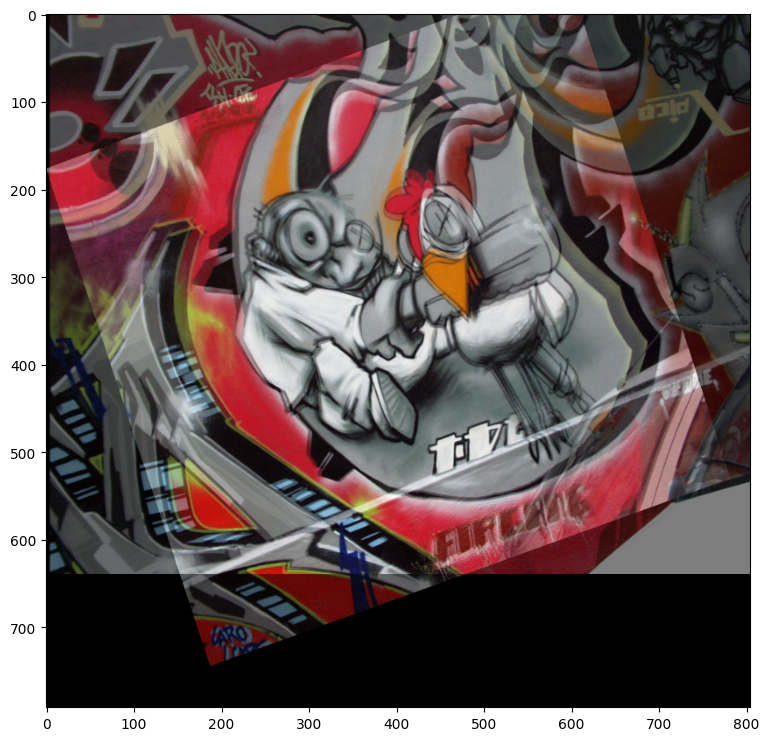

In [101]:
def stitch_images(img1, img2, transform):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    # Warp corners of image 1 to coordinates system of image 2.
    corners = np.array([
        [0., w1, w1, 0.],
        [0., 0., h1, h1],
        [1., 1., 1., 1.]
    ])
    new_corners = transform @ corners
    new_corners /= new_corners[2, :]
    # Calculate range of warped image 1.
    l = np.min(new_corners[0, :])
    r = np.max(new_corners[0, :])
    t = np.min(new_corners[1, :])
    b = np.max(new_corners[1, :])
    # Calculate size of the stitched image.
    l = np.min((l,  0))
    r = np.max((r, w2))
    t = np.min((t,  0))
    b = np.max((b, h2))
    w = int(np.round(r-l))
    h = int(np.round(b-t))
    # Calculate how much we should shift the stitched image.
    dx = max((-l, 0.))
    dy = max((-h, 0.))
    shift = np.array([
        [1., 0., dx],
        [0., 1., dy],
        [0., 0., 1.]
    ])

    # Warp input images and overlay them.
    warped_img1 = cv2.warpPerspective(img1, shift @ transform, (w, h))
    warped_img2 = cv2.warpPerspective(img2, shift, (w, h))
    overlayed_img = cv2.addWeighted(warped_img1, 0.5, warped_img2, 0.5, 0.0)
    return overlayed_img


stitched_img = stitch_images(img1, img2, transform)
plt.imshow(cv2.cvtColor(stitched_img, cv2.COLOR_BGR2RGB))
plt.show()

# Disparity Map

In this problem you will find dense correspondences between the stereo image pair below and calculate the disparity map. This will be done by doing template matching between image windows.

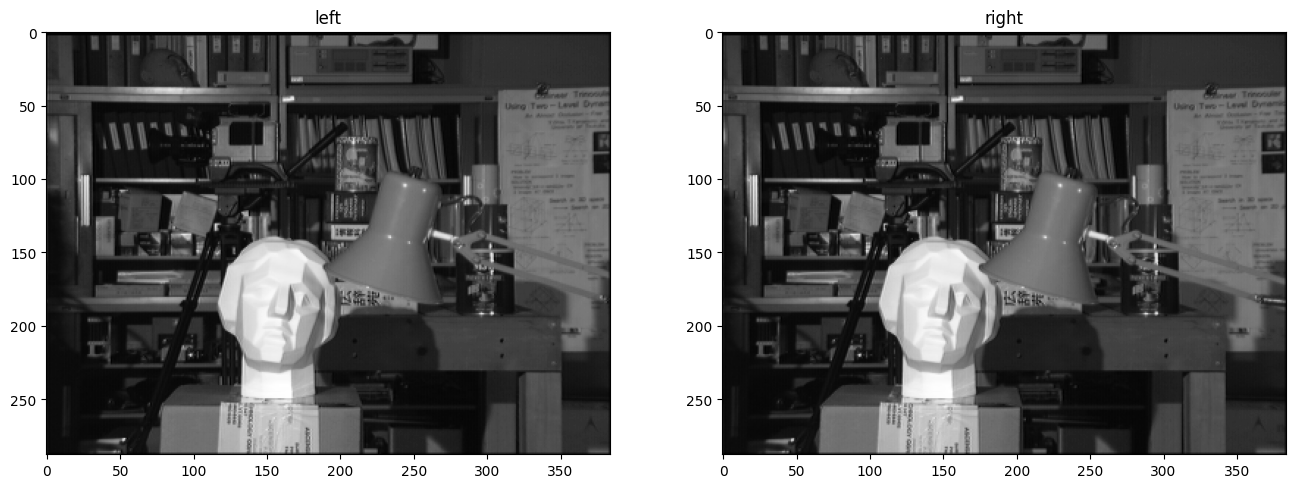

In [102]:
img1 = cv2.imread('data/left.bmp')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGRA2GRAY) / 255.

img2 = cv2.imread('data/right.bmp')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGRA2GRAY) / 255.

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img1, cmap='gray')
ax1.set_title('left')
ax2.imshow(img2, cmap='gray')
ax2.set_title('right')
plt.show()

In the cell below, I implement a system to calculate the disparity map and visualize the results. You can assume that the camera angle of the images are already rectified, so the epipolar lines are all horizontal. Use SSD as the similarity measure between windows. Set the window size to `7` and the maximum disparity value to `40`.

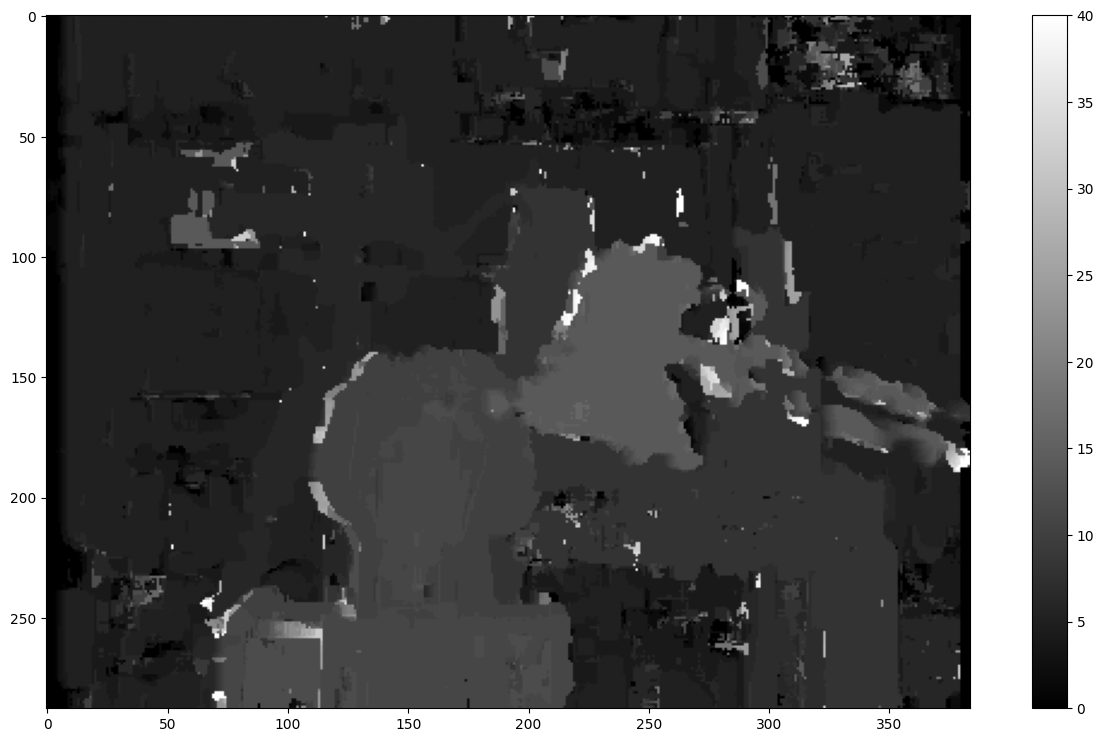

In [103]:
from scipy.signal import convolve2d


assert img1.shape == img2.shape
h, w = img1.shape

dmin, dmax = 0, 40  # disparity search range
s = 7  # windows size

best = np.inf * np.ones_like(img1)
disp = np.zeros_like(img1)
# loop through disparities
for k in range(dmin, dmax + 1):
    im2s = np.zeros_like(img1)
    # compute overlap image from I2 shifted to the right by k
    if k == 0:
        # 0 disparity so image 2 stays the same after shifting 0
        im2s = img2
    else:
        # set all columns from k onward equal to all columns up to k, shifting image to right by k
        im2s[:, k:] = img2[:, :-k]
    # squared differences between I1 and im2s
    prod = (img1 - im2s) ** 2
    # 2d convolution with averaging filter
    # averaging filter is a kernel of window size and each pixel is average of all pixels (1 / s * s)
    kernel = np.ones((s, s)) / (s * s)
    # 2d convolution using convolve2d, gets average error for each pixel within window size
    CC = convolve2d(prod, kernel, mode='same')
    # find indices where CC < best
    update_indices = CC < best
    # update indices in disp to equal k
    disp[update_indices] = k
    # update best, use indices where CC < best
    best[update_indices] = CC[update_indices]

plt.imshow(disp, cmap='gray')
plt.colorbar()
plt.show()